In [97]:
# Author: Roshan Ram
# AndrewID: rram

import yfinance as yfinance

import module_manager
module_manager.review()

import yfinance as yf # to pull stock data with yf.download(name, yyyy-mm-dd of opening, yyyy-mm-dd of opening)

import numpy as np # used for everything lol
import pandas as pd # data mainpulation
import matplotlib.pyplot as plt # graphing/plotting
from keras import *


#####
import numpy as np
import os
import sys
import time
import pandas as pd 
from tqdm._tqdm_notebook import tqdm_notebook
import pickle
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras import optimizers
# from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import logging
####

%matplotlib inline 
#just to make stuff look nice

In [98]:
stock = None
while not isinstance(stock, str):
    stock = input("Enter your desired stock. Only alphanumeric characters please.")
openingInp = input("Enter your desired opening date. (yyyy-mm-dd)") #'2016-01-01'
closingInp = input("Enter your desired closing date. (yyyy-mm-dd)") # '2019-08-01'


data = yf.download(stock, openingInp, closingInp)

Enter your desired stock. Only alphanumeric characters please.AAPL
Enter your desired opening date. (yyyy-mm-dd)2016-01-01
Enter your desired closing date. (yyyy-mm-dd)2019-08-01
[*********************100%***********************]  1 of 1 completed


In [99]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

TIME_STEPS = 10 # [rram]
BATCH_SIZE = 32 # [rram]


#####
params = {
    "batch_size": 20,  # 20<16<10, 25 was a bust
    "epochs": 300,
    "lr": 0.00010000,
    "time_steps": 60
}

iter_changes = "dropout_layers_0.4_0.4"

# INPUT_PATH = PATH_TO_DRIVE_ML_DATA+"/inputs"
OUTPUT_PATH = '~/Desktop'
TIME_STEPS = params["time_steps"]
BATCH_SIZE = params["batch_size"]
stime = time.time()
###


train_cols = ["Open","High","Low","Close","Volume"]
df_train, df_test = train_test_split(data, train_size=0.8, test_size=0.2, shuffle=False)
print("Train and Test size", len(df_train), len(df_test))
# scale the feature MinMax, build array
x = df_train.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.transform(df_test.loc[:,train_cols])

Train and Test size 720 181


In [100]:

def build_timeseries(mat, y_col_index):
    # y_col_index is the index of column that would act as output column
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    
    for i in (range(dim_0)):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
    print("length of time-series i/o",x.shape,y.shape)
    return x, y

In [101]:
def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat

In [102]:
x_t, y_t = build_timeseries(x_train, 3)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
x_temp, y_temp = build_timeseries(x_test, 3)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)

length of time-series i/o (660, 60, 5) (660,)
length of time-series i/o (121, 60, 5) (121,)


In [103]:
# def create_model():
lstm_model = Sequential()
lstm_model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]), dropout=0.0, recurrent_dropout=0.0, stateful=True,     kernel_initializer='random_uniform'))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(20,activation='relu'))
lstm_model.add(Dense(1,activation='sigmoid'))
optimizer = optimizers.RMSprop(lr=0.00010000)
lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)

In [104]:
model = lstm_model

In [109]:

csv_logger = CSVLogger(os.path.join(OUTPUT_PATH, 'your_log_name' + '.log'), append=True)

# epochs = params['epochs']

history = model.fit(x_t, y_t, epochs= 300, verbose=2, batch_size=BATCH_SIZE,
                    shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
                    trim_dataset(y_val, BATCH_SIZE))) #callbacks=[csv_logger])

# history = model.fit(x_t, y_t, epochs=params["epochs"], verbose=2, batch_size=BATCH_SIZE,
#                         shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
#                         trim_dataset(y_val, BATCH_SIZE)), callbacks=[es, mcp, csv_logger])

Train on 660 samples, validate on 60 samples
Epoch 1/300
 - 2s - loss: 0.0736 - val_loss: 0.0455
Epoch 2/300
 - 1s - loss: 0.0704 - val_loss: 0.0360
Epoch 3/300
 - 1s - loss: 0.0681 - val_loss: 0.0280
Epoch 4/300
 - 1s - loss: 0.0654 - val_loss: 0.0213
Epoch 5/300
 - 1s - loss: 0.0625 - val_loss: 0.0145
Epoch 6/300
 - 1s - loss: 0.0594 - val_loss: 0.0087
Epoch 7/300
 - 1s - loss: 0.0537 - val_loss: 0.0042
Epoch 8/300
 - 1s - loss: 0.0473 - val_loss: 0.0084
Epoch 9/300
 - 1s - loss: 0.0385 - val_loss: 0.0122
Epoch 10/300
 - 1s - loss: 0.0284 - val_loss: 0.0092
Epoch 11/300
 - 1s - loss: 0.0211 - val_loss: 0.0101
Epoch 12/300
 - 1s - loss: 0.0171 - val_loss: 0.0081
Epoch 13/300
 - 1s - loss: 0.0140 - val_loss: 0.0076
Epoch 14/300
 - 1s - loss: 0.0115 - val_loss: 0.0082
Epoch 15/300
 - 1s - loss: 0.0107 - val_loss: 0.0075
Epoch 16/300
 - 1s - loss: 0.0100 - val_loss: 0.0069
Epoch 17/300
 - 1s - loss: 0.0092 - val_loss: 0.0063
Epoch 18/300
 - 1s - loss: 0.0087 - val_loss: 0.0059
Epoch 19/3

Epoch 154/300
 - 1s - loss: 0.0023 - val_loss: 0.0199
Epoch 155/300
 - 1s - loss: 0.0024 - val_loss: 0.0174
Epoch 156/300
 - 1s - loss: 0.0024 - val_loss: 0.0178
Epoch 157/300
 - 1s - loss: 0.0023 - val_loss: 0.0169
Epoch 158/300
 - 1s - loss: 0.0023 - val_loss: 0.0150
Epoch 159/300
 - 1s - loss: 0.0023 - val_loss: 0.0213
Epoch 160/300
 - 1s - loss: 0.0025 - val_loss: 0.0138
Epoch 161/300
 - 1s - loss: 0.0023 - val_loss: 0.0166
Epoch 162/300
 - 1s - loss: 0.0022 - val_loss: 0.0212
Epoch 163/300
 - 1s - loss: 0.0024 - val_loss: 0.0175
Epoch 164/300
 - 1s - loss: 0.0023 - val_loss: 0.0167
Epoch 165/300
 - 1s - loss: 0.0023 - val_loss: 0.0151
Epoch 166/300
 - 1s - loss: 0.0024 - val_loss: 0.0158
Epoch 167/300
 - 1s - loss: 0.0024 - val_loss: 0.0204
Epoch 168/300
 - 1s - loss: 0.0024 - val_loss: 0.0148
Epoch 169/300
 - 1s - loss: 0.0022 - val_loss: 0.0190
Epoch 170/300
 - 1s - loss: 0.0024 - val_loss: 0.0149
Epoch 171/300
 - 1s - loss: 0.0022 - val_loss: 0.0163
Epoch 172/300
 - 1s - loss: 

Error is 0.016638167803824815 (60,) (60,)
[0.88200986 0.8814492  0.8817694  0.88026524 0.8771469  0.8694947
 0.86441493 0.8610784  0.8577176  0.8542801  0.8488984  0.8460444
 0.8427063  0.83744776 0.8343072 ]
[0.79390387 0.79418605 0.77880474 0.75382762 0.67296971 0.6937134
 0.70965917 0.70373243 0.6961123  0.65441327 0.67917874 0.65222603
 0.63021238 0.62534395 0.62012272]
[215.34726 215.2678  215.31319 215.1     214.65804 213.57349 212.85353
 212.38065 211.90433 211.41713 210.65439 210.24988 209.77676 209.03148
 208.58636]
[202.86000061 202.8999939  200.72000122 197.17999268 185.72000122
 188.66000366 190.91999817 190.08000183 189.         183.08999634
 186.6000061  182.77999878 179.66000366 178.97000122 178.22999573]


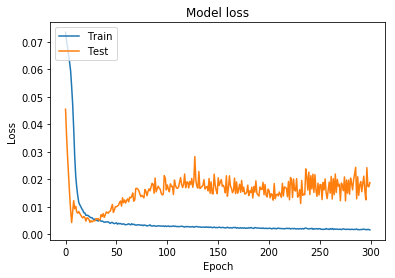

In [110]:
y_pred = model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)
print(y_pred[0:15])
print(y_test_t[0:15])

# convert the predicted value to range of real data
y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
# min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
# min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[0:15])
print(y_test_t_org[0:15])

# Visualize the training data
from matplotlib import pyplot as plt
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
#plt.show()

In [111]:
y_pred = lstm_model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)
print(y_pred[0:15])
print(y_test_t[0:15])
y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] # min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] # min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[0:15])
print(y_test_t_org[0:15])

Error is 0.016784886028233657 (60,) (60,)
[0.88565946 0.88468194 0.88456017 0.88272214 0.879333   0.8714853
 0.8662174  0.86267745 0.8591162  0.85551137 0.8499459  0.8469356
 0.84346163 0.8381137  0.83491224]
[0.79390387 0.79418605 0.77880474 0.75382762 0.67296971 0.6937134
 0.70965917 0.70373243 0.6961123  0.65441327 0.67917874 0.65222603
 0.63021238 0.62534395 0.62012272]
[215.86452 215.72598 215.70871 215.44821 214.96786 213.85562 213.109
 212.60728 212.10254 211.59163 210.80284 210.37619 209.88382 209.12585
 208.67212]
[202.86000061 202.8999939  200.72000122 197.17999268 185.72000122
 188.66000366 190.91999817 190.08000183 189.         183.08999634
 186.6000061  182.77999878 179.66000366 178.97000122 178.22999573]


NameError: name 'print_time' is not defined

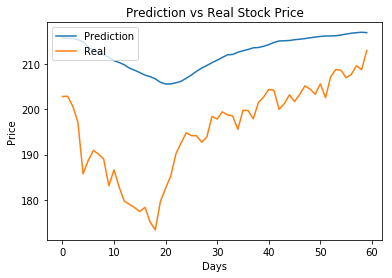

In [112]:
from matplotlib import pyplot as plt
plt.figure()
plt.plot(y_pred_org)
plt.plot(y_test_t_org)
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')
#plt.show()
print_time("program completed ", stime)

In [ ]:
# is_update_model = True
# if model is None or is_update_model:
#     from keras import backend as K
#     print("Building model...")
#     print("checking if GPU available", K.tensorflow_backend._get_available_gpus())
#     model = create_model()
    
#     es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,
#                        patience=40, min_delta=0.0001)
    
#     mcp = ModelCheckpoint(os.path.join(OUTPUT_PATH,
#                           "best_model.h5"), monitor='val_loss', verbose=1,
#                           save_best_only=True, save_weights_only=False, mode='min', period=1)

#     # Not used here. But leaving it here as a reminder for future
#     r_lr_plat = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=30, 
#                                   verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
    
#     csv_logger = CSVLogger(os.path.join(OUTPUT_PATH, 'training_log_' + time.ctime().replace(" ","_") + '.log'), append=True)
    
#     history = model.fit(x_t, y_t, epochs=params["epochs"], verbose=2, batch_size=BATCH_SIZE,
#                         shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
#                         trim_dataset(y_val, BATCH_SIZE)), callbacks=[es, mcp, csv_logger])
    
#     print("saving model...")
#     pickle.dump(model, open("lstm_model", "wb"))

# # model.evaluate(x_test_t, y_test_t, batch_size=BATCH_SIZE
# y_pred = model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
# y_pred = y_pred.flatten()
# y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
# error = mean_squared_error(y_test_t, y_pred)
# print("Error is", error, y_pred.shape, y_test_t.shape)
# print(y_pred[0:15])
# print(y_test_t[0:15])

# # convert the predicted value to range of real data
# y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
# # min_max_scaler.inverse_transform(y_pred)
# y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
# # min_max_scaler.inverse_transform(y_test_t)
# print(y_pred_org[0:15])
# print(y_test_t_org[0:15])

# # Visualize the training data
# from matplotlib import pyplot as plt
# plt.figure()
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# #plt.show()
# plt.savefig(os.path.join(OUTPUT_PATH, 'train_vis_BS_'+str(BATCH_SIZE)+"_"+time.ctime()+'.png'))

# # load the saved best model from above
# saved_model = load_model(os.path.join(OUTPUT_PATH, 'best_model.h5')) # , "lstm_best_7-3-19_12AM",
# print(saved_model)

# y_pred = saved_model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
# y_pred = y_pred.flatten()
# y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
# error = mean_squared_error(y_test_t, y_pred)
# print("Error is", error, y_pred.shape, y_test_t.shape)
# print(y_pred[0:15])
# print(y_test_t[0:15])
# y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] # min_max_scaler.inverse_transform(y_pred)
# y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] # min_max_scaler.inverse_transform(y_test_t)
# print(y_pred_org[0:15])
# print(y_test_t_org[0:15])

# # Visualize the prediction
# from matplotlib import pyplot as plt
# plt.figure()
# plt.plot(y_pred_org)
# plt.plot(y_test_t_org)
# plt.title('Prediction vs Real Stock Price')
# plt.ylabel('Price')
# plt.xlabel('Days')
# plt.legend(['Prediction', 'Real'], loc='upper left')
# #plt.show()
# plt.savefig(os.path.join(OUTPUT_PATH, 'pred_vs_real_BS'+str(BATCH_SIZE)+"_"+time.ctime()+'.png'))
# print_time("program completed ", stime)